# CNN Baseline - iWildCam 2019

Breakdown of this notebook:
1. **Loading the 32x32 dataset**: Load the data generated in *Reducing Image Sizes to 32x32*.
2. **Create Callback for F1 Score**: F1-macro score is the official metric of the competition. We create a callback to keep track of that value as we train the model.
3. **Creating and Training the Model**: Create a simple model (taken from the official Keras tutorial) and train it.
4. **Evaluation**: Display the plots from the training history.
5. **Submission**: Run predictions with `model.predict`, and create submission csv file.

### References
* [cifar10_cnn_keras.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py): Heavily inspired from this tutorial created by the Keras team. The architecture and training process is directly taken from them.
* [Keras CNN Starter - PetFinder](https://www.kaggle.com/xhlulu/keras-cnn-starter-petfinder/): History plot and submission are inspired by this kernel
* [Reducing Image Sizes to 32x32](https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32): Image data (`X_train`, `X_test`) come from the output of this kernel.
* [How to compute f1 score for each epoch in Keras](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2): Needed to compute the F1 Score after each epoch.

In [5]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [6]:
os.listdir('../input')

['fft-test-image', 'reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6']

# 0. FFT Setup

In [7]:
import cv2
import numpy as np
import tensorflow as tf
# from tensorflow import signal
import numpy.fft as fft
import matplotlib as mpl

import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['image.cmap'] = "gray"

In [8]:

def image_n_fft(real_img, plot=False):
    if plot==True:
#         real_img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        Img = fft.fft2(real_img)
        mag = np.abs(fft.fftshift(Img))
        plt.subplot(1,2,1)
        plt.imshow(real_img); plt.axis('off');
        plt.subplot(1,2,2)
        plt.imshow(20*np.log10(mag**2 + 1)); plt.axis('off'); plt.title('Power (dB)');
    return fft.fft2(real_img)

In [9]:
def image_n_fft_ranged(real_img, range_low, range_high, plot=False):
    x, y = np.meshgrid(range(real_img.shape[0]), range(real_img.shape[1]))
    r = np.sqrt((x - x.mean())**2 + (y - y.mean())**2)
        
    if plot==True:
#         real_img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#         print(type(real_img))
        Img = fft.fft2(real_img)

        _Img = np.where((r > range_low) & (r < range_high), fft.fftshift(Img), 0)
        mag = np.abs(_Img)
        plt.subplot(1,2,1)
        plt.imshow(fft.ifft2(fft.fftshift(_Img)).real); plt.axis('off');
        plt.subplot(1,2,2)
        plt.imshow(20*np.log10(mag**2 + 1)); plt.axis('off'); plt.title('Power (dB)');
        print(type(fft.ifft2(fft.fftshift(_Img)).real))
        print(fft.ifft2(fft.fftshift(_Img)).real)
    
    return np.where((r > range_low) & (r < range_high), fft.fftshift(fft.fft2(real_img)), 0)

array([[ 6.32583950e+07      +0.j        ,
        -3.82785724e+06-1243563.69750258j,
        -2.19446775e+06+2484085.27256107j, ...,
        -1.87848537e+05 +997766.70685262j,
        -2.19446775e+06-2484085.27256107j,
        -3.82785724e+06+1243563.69750258j],
       [-7.08443323e+06-2880064.69855541j,
         8.68545260e+05 +277713.1103071j ,
         2.55913946e+06-2426482.9691034j , ...,
         7.02057946e+04  +22034.06267725j,
         2.38602999e+06 +404183.72010101j,
        -5.11195315e+06 -744233.31960675j],
       [ 8.09115887e+05-1912039.26633563j,
        -5.26427476e+05 -772299.3815135j ,
        -7.08210545e+04 +815050.56381426j, ...,
         7.10894092e+05-1254758.55562614j,
        -3.57206446e+04 +317388.74406846j,
        -4.08389229e+05 +934441.38538909j],
       ...,
       [ 2.02554094e+05 -932594.047056j  ,
         5.51799327e+05+1328428.54044855j,
        -3.61180400e+05 -173652.52259134j, ...,
         8.32755943e+05 -558058.91547562j,
        -6.36016353

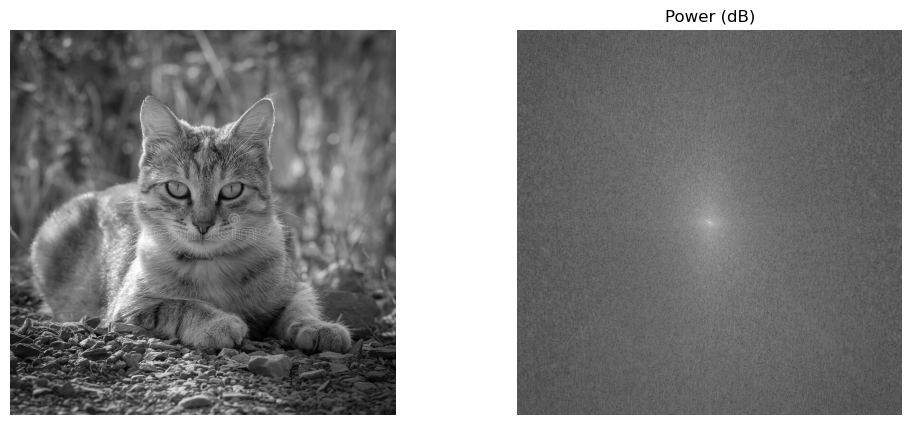

In [10]:
real_img = cv2.imread('../input/fft-test-image/test.jpg', cv2.IMREAD_GRAYSCALE)
image_n_fft(real_img, True)

<class 'numpy.ndarray'>
[[66.69368718 62.20509322 62.56568154 ... 78.73723774 78.62438737
  75.04024141]
 [65.06548959 63.19063917 62.40620672 ... 78.6521176  78.41295013
  77.48627978]
 [65.7837265  64.86136866 61.95549939 ... 79.16752251 77.66741275
  76.55730373]
 ...
 [72.69135393 70.56972007 70.7808501  ... 27.29783683 35.57287462
  39.48477512]
 [70.43401531 67.58639824 68.62253422 ... 34.43859067 41.03136529
  44.49093088]
 [76.51030599 78.43485343 75.32446309 ... 37.31220206 43.05643651
  51.56384417]]


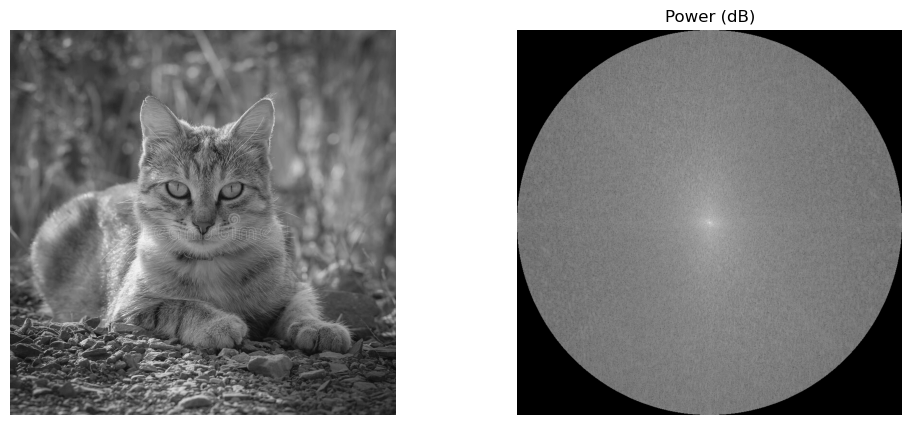

In [16]:
image_n_fft_ranged(real_img, 0 ,0.5*real_img.shape[0], True);

<class 'numpy.ndarray'>
[[62.48791732 65.4404321  68.16819038 ... 54.39629251 56.76631206
  59.52573056]
 [66.22780932 68.07033184 69.66834321 ... 60.86067814 62.46619699
  64.30454723]
 [69.51253526 70.2784268  70.77741781 ... 66.77362822 67.64421395
  68.59419606]
 ...
 [51.47890117 57.52584504 63.36723097 ... 35.62123079 40.20193595
  45.58824142]
 [54.7882262  59.88548192 64.77964689 ... 41.3551108  45.23806244
  49.8039702 ]
 [58.56798945 62.62001264 66.46187704 ... 47.75473446 50.8925845
  54.57232305]]


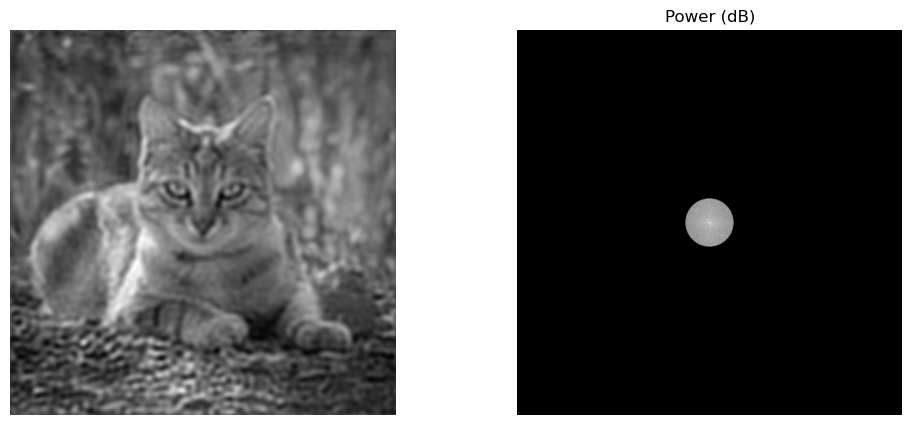

In [23]:
image_n_fft_ranged(real_img, 0 ,0.5*real_img.shape[0]/8, True);

<class 'numpy.ndarray'>
[[  6.57924302   6.88441162   6.82205539 ...   3.06779691   4.38426024
    5.69651007]
 [  8.01521573   5.97329101   3.74437786 ...  11.50569573  10.68805544
    9.59249953]
 [  7.3670634    3.41766079  -0.54016939 ...  16.7793656   14.12289291
   10.98732686]
 ...
 [ -8.49177517  -3.1654811    0.80830139 ... -27.82065494 -21.8697772
  -15.00917848]
 [ -2.75831853   1.48690117   4.83459611 ... -18.25160642 -13.38157071
   -7.90365716]
 [  2.77317378   5.31143905   7.26324781 ...  -7.39745755  -4.08539888
   -0.47234402]]


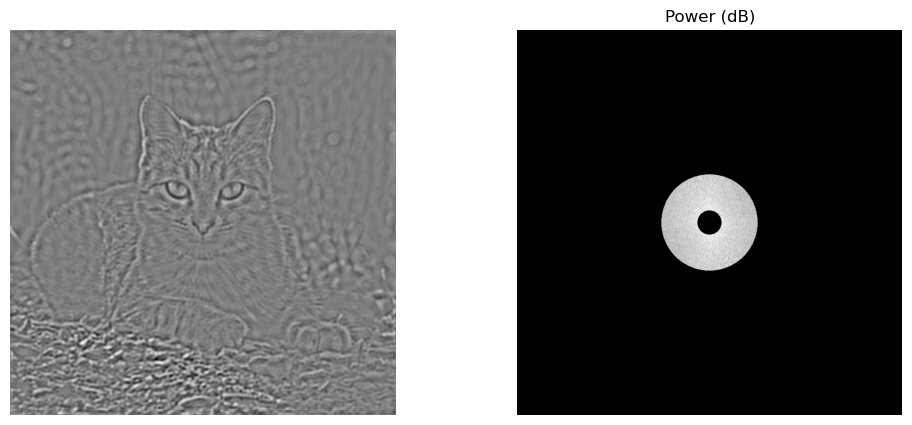

In [24]:
image_n_fft_ranged(real_img, 0.5*real_img.shape[0]/16 ,0.5*real_img.shape[0]/4, True);

## 1. Loading the 32x32 dataset

In [8]:
# The data, split between train and test sets:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [9]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [10]:
i = 0
for pic in x_train:
#     pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

#     print(pic.shape)
    if i == 0:
        i+=1
        print(cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY))
    pic = image_n_fft_ranged(cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY), 0, 16)
    

for pic in x_test:
    pic = image_n_fft_ranged(cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY), 0, 16)
    
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

[[0.01176471 0.00784314 0.01568628 ... 0.03529412 0.01568628 0.        ]
 [0.19607845 0.21960784 0.1882353  ... 0.16078432 0.14117648 0.20784314]
 [0.12941177 0.18431373 0.18039216 ... 0.16078432 0.15686275 0.14509805]
 ...
 [0.3529412  0.36078432 0.2627451  ... 0.1764706  0.16470589 0.14509805]
 [0.36862746 0.34901962 0.26666668 ... 0.14901961 0.14117648 0.13725491]
 [0.3764706  0.34117648 0.2509804  ... 0.15194118 0.1234902  0.12823921]]
x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


## 2. Create Callback for F1 score

In [11]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        

    def on_epoch_end(self, epoch, logs={}):
        
#         print(self.validation_data[:2])
#         X_val, y_val = self.validation_data[:2]
#         X_val, y_val = x_train, y_train
        y_pred = self.model.predict(x_train[:1000])

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_train[:1000], y_pred_cat, average='macro')
        _val_recall = recall_score(y_train[:1000], y_pred_cat, average='macro')
        _val_precision = precision_score(y_train[:1000], y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

## 3. Creating and Training the Model

In [12]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
print(save_dir)
model_name = 'keras_cnn_model.h5'

/kaggle/working/models


In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [14]:
# print(x_train[0])
# os.environ['TF_DISABLE_NXPLANNER'] = '1'

In [15]:
%%time
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
#     validation_data=(x_val, y_val),
    shuffle=True
)

Epoch 1/30


2023-04-28 00:03:15.431709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.
val_f1: 0.4892 — val_precision: 0.6310 — val_recall: 0.4553
2761/2761 [==============================] - 27s 7ms/step - loss: 0.6947 - accuracy: 0.7831 - val_loss: 0.4919 - val_accuracy: 0.8423
Epoch 2/30
  11/2761 [..............................] - ETA: 34s - loss: 0.5281 - accuracy: 0.8239

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.
val_f1: 0.5991 — val_precision: 0.6712 — val_recall: 0.5699
2761/2761 [==============================] - 18s 7ms/step - loss: 0.5023 - accuracy: 0.8373 - val_loss: 0.4177 - val_accuracy: 0.8645
Epoch 3/30
  28/2761 [..............................] - ETA: 16s - loss: 0.4895 - accuracy: 0.8443

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.
val_f1: 0.6061 — val_precision: 0.6657 — val_recall: 0.5823
2761/2761 [==============================] - 17s 6ms/step - loss: 0.4467 - accuracy: 0.8533 - val_loss: 0.3662 - val_accuracy: 0.8772
Epoch 4/30
  28/2761 [..............................] - ETA: 15s - loss: 0.4063 - accuracy: 0.8677

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.
val_f1: 0.7018 — val_precision: 0.7243 — val_recall: 0.6877
2761/2761 [==============================] - 18s 6ms/step - loss: 0.4112 - accuracy: 0.8641 - val_loss: 0.3323 - val_accuracy: 0.8886
Epoch 5/30
  28/2761 [..............................] - ETA: 16s - loss: 0.4245 - accuracy: 0.8577

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3847 - accuracy: 0.
val_f1: 0.7184 — val_precision: 0.7647 — val_recall: 0.6867
2761/2761 [==============================] - 18s 7ms/step - loss: 0.3846 - accuracy: 0.8731 - val_loss: 0.3179 - val_accuracy: 0.8942
Epoch 6/30
  16/2761 [..............................] - ETA: 30s - loss: 0.3681 - accuracy: 0.8828

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3651 - accuracy: 0.
val_f1: 0.7101 — val_precision: 0.7393 — val_recall: 0.6969
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3651 - accuracy: 0.8783 - val_loss: 0.3060 - val_accuracy: 0.8993
Epoch 7/30
  26/2761 [..............................] - ETA: 16s - loss: 0.3400 - accuracy: 0.8840

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3488 - accuracy: 0.
val_f1: 0.7250 — val_precision: 0.7538 — val_recall: 0.7046
2761/2761 [==============================] - 18s 7ms/step - loss: 0.3487 - accuracy: 0.8826 - val_loss: 0.2917 - val_accuracy: 0.9035
Epoch 8/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3322 - accuracy: 0.8890

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3387 - accuracy: 0.
val_f1: 0.7716 — val_precision: 0.7781 — val_recall: 0.7692
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3387 - accuracy: 0.8855 - val_loss: 0.2860 - val_accuracy: 0.9059
Epoch 9/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3174 - accuracy: 0.9029

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 3ms/step - loss: 0.3273 - accuracy: 
val_f1: 0.7538 — val_precision: 0.7783 — val_recall: 0.7381
2761/2761 [==============================] - 18s 7ms/step - loss: 0.3273 - accuracy: 0.8897 - val_loss: 0.2763 - val_accuracy: 0.9098
Epoch 10/30
  28/2761 [..............................] - ETA: 15s - loss: 0.3063 - accuracy: 0.8901

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.
val_f1: 0.7848 — val_precision: 0.7985 — val_recall: 0.7761
2761/2761 [==============================] - 17s 6ms/step - loss: 0.3190 - accuracy: 0.8920 - val_loss: 0.2586 - val_accuracy: 0.9136
Epoch 11/30
  28/2761 [..............................] - ETA: 15s - loss: 0.3020 - accuracy: 0.8990

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3100 - accuracy: 0.
val_f1: 0.7475 — val_precision: 0.7613 — val_recall: 0.7389
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3100 - accuracy: 0.8941 - val_loss: 0.2609 - val_accuracy: 0.9122
Epoch 12/30
  28/2761 [..............................] - ETA: 16s - loss: 0.3008 - accuracy: 0.8973

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.
val_f1: 0.7613 — val_precision: 0.7743 — val_recall: 0.7530
2761/2761 [==============================] - 18s 6ms/step - loss: 0.3037 - accuracy: 0.8963 - val_loss: 0.2564 - val_accuracy: 0.9153
Epoch 13/30
  28/2761 [..............................] - ETA: 15s - loss: 0.3147 - accuracy: 0.8873

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2995 - accuracy: 0.
val_f1: 0.7989 — val_precision: 0.8333 — val_recall: 0.7773
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2995 - accuracy: 0.8982 - val_loss: 0.2549 - val_accuracy: 0.9158
Epoch 14/30
  28/2761 [..............................] - ETA: 15s - loss: 0.2569 - accuracy: 0.9118

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.
val_f1: 0.8017 — val_precision: 0.8031 — val_recall: 0.8050
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2940 - accuracy: 0.8994 - val_loss: 0.2477 - val_accuracy: 0.9188
Epoch 15/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2727 - accuracy: 0.9107

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2868 - accuracy: 0.
val_f1: 0.8203 — val_precision: 0.8215 — val_recall: 0.8206
2761/2761 [==============================] - 17s 6ms/step - loss: 0.2868 - accuracy: 0.9021 - val_loss: 0.2473 - val_accuracy: 0.9174
Epoch 16/30
  28/2761 [..............................] - ETA: 15s - loss: 0.3068 - accuracy: 0.8912

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.
val_f1: 0.7984 — val_precision: 0.8217 — val_recall: 0.7817
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2878 - accuracy: 0.9010 - val_loss: 0.2437 - val_accuracy: 0.9183
Epoch 17/30
  27/2761 [..............................] - ETA: 16s - loss: 0.2884 - accuracy: 0.8993

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2786 - accuracy: 0.
val_f1: 0.7959 — val_precision: 0.8094 — val_recall: 0.7876
2761/2761 [==============================] - 17s 6ms/step - loss: 0.2786 - accuracy: 0.9037 - val_loss: 0.2444 - val_accuracy: 0.9184
Epoch 18/30
  28/2761 [..............................] - ETA: 15s - loss: 0.2617 - accuracy: 0.9118

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2762 - accuracy: 0.
val_f1: 0.7871 — val_precision: 0.8005 — val_recall: 0.7800
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2762 - accuracy: 0.9054 - val_loss: 0.2351 - val_accuracy: 0.9218
Epoch 19/30
  28/2761 [..............................] - ETA: 15s - loss: 0.2483 - accuracy: 0.9124

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2756 - accuracy: 0.
val_f1: 0.7961 — val_precision: 0.8088 — val_recall: 0.7862
2761/2761 [==============================] - 17s 6ms/step - loss: 0.2756 - accuracy: 0.9056 - val_loss: 0.2300 - val_accuracy: 0.9227
Epoch 20/30
  18/2761 [..............................] - ETA: 26s - loss: 0.2690 - accuracy: 0.9149

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.
val_f1: 0.8285 — val_precision: 0.8263 — val_recall: 0.8405
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2688 - accuracy: 0.9073 - val_loss: 0.2284 - val_accuracy: 0.9235
Epoch 21/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2407 - accuracy: 0.9163

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2664 - accuracy: 0.
val_f1: 0.8020 — val_precision: 0.8128 — val_recall: 0.7964
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2664 - accuracy: 0.9081 - val_loss: 0.2286 - val_accuracy: 0.9241
Epoch 22/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2545 - accuracy: 0.9180

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.
val_f1: 0.8255 — val_precision: 0.8358 — val_recall: 0.8205
2761/2761 [==============================] - 17s 6ms/step - loss: 0.2631 - accuracy: 0.9094 - val_loss: 0.2351 - val_accuracy: 0.9240
Epoch 23/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2423 - accuracy: 0.9152

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.
val_f1: 0.8218 — val_precision: 0.8623 — val_recall: 0.8080
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2601 - accuracy: 0.9105 - val_loss: 0.2221 - val_accuracy: 0.9261
Epoch 24/30
  28/2761 [..............................] - ETA: 15s - loss: 0.2565 - accuracy: 0.9124

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2578 - accuracy: 0.
val_f1: 0.8164 — val_precision: 0.8311 — val_recall: 0.8070
2761/2761 [==============================] - 17s 6ms/step - loss: 0.2578 - accuracy: 0.9106 - val_loss: 0.2216 - val_accuracy: 0.9260
Epoch 25/30
  26/2761 [..............................] - ETA: 17s - loss: 0.2456 - accuracy: 0.9117

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.
val_f1: 0.8165 — val_precision: 0.8328 — val_recall: 0.8049
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2566 - accuracy: 0.9118 - val_loss: 0.2172 - val_accuracy: 0.9273
Epoch 26/30
  28/2761 [..............................] - ETA: 16s - loss: 0.2471 - accuracy: 0.9107

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2530 - accuracy: 0.
val_f1: 0.8260 — val_precision: 0.8294 — val_recall: 0.8322
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2530 - accuracy: 0.9121 - val_loss: 0.2192 - val_accuracy: 0.9260
Epoch 27/30
  28/2761 [..............................] - ETA: 15s - loss: 0.2460 - accuracy: 0.9107

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.
val_f1: 0.7822 — val_precision: 0.7959 — val_recall: 0.7750
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2532 - accuracy: 0.9126 - val_loss: 0.2227 - val_accuracy: 0.9275
Epoch 28/30
  28/2761 [..............................] - ETA: 15s - loss: 0.2246 - accuracy: 0.9247

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 3ms/step - loss: 0.2510 - accuracy: 0.
val_f1: 0.8394 — val_precision: 0.8437 — val_recall: 0.8387
2761/2761 [==============================] - 18s 6ms/step - loss: 0.2511 - accuracy: 0.9132 - val_loss: 0.2136 - val_accuracy: 0.9281
Epoch 29/30
  23/2761 [..............................] - ETA: 19s - loss: 0.2406 - accuracy: 0.9158

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2491 - accuracy: 0.
val_f1: 0.8220 — val_precision: 0.8297 — val_recall: 0.8272
2761/2761 [==============================] - 17s 6ms/step - loss: 0.2493 - accuracy: 0.9141 - val_loss: 0.2189 - val_accuracy: 0.9262
Epoch 30/30
  22/2761 [..............................] - ETA: 20s - loss: 0.2221 - accuracy: 0.9226

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.
val_f1: 0.8294 — val_precision: 0.8342 — val_recall: 0.8328
2761/2761 [==============================] - 18s 7ms/step - loss: 0.2420 - accuracy: 0.9162 - val_loss: 0.2120 - val_accuracy: 0.9287


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 9min 8s, sys: 39.3 s, total: 9min 47s
Wall time: 9min 27s


Save model and weights

In [16]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/models/keras_cnn_model.h5 


## 4. Evaluation

KeyError: "None of [Index(['acc', 'val_acc'], dtype='object')] are in the [columns]"

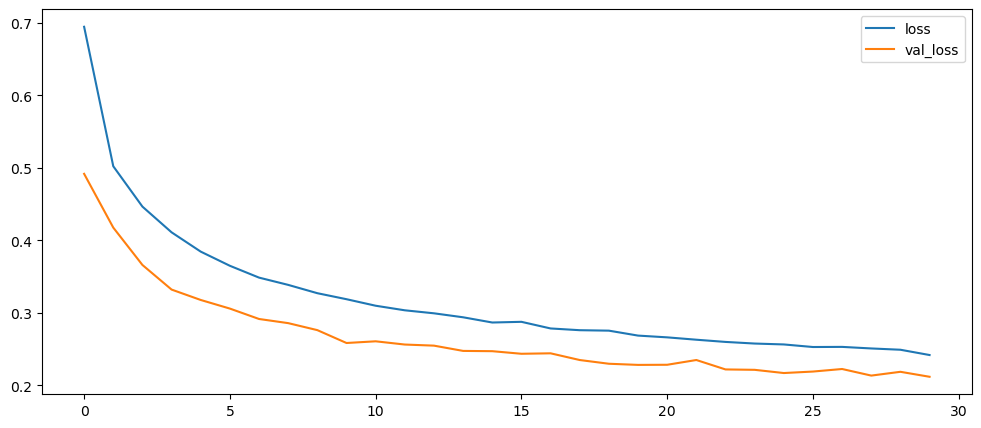

In [17]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

## 5. Submission

In [19]:
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)
print(submission_df.shape)
submission_df.head()

4805/4805 [==============================] - 10s 2ms/step
(153730, 4)


,Unnamed: 0,Id,Category,Predicted
0,0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0,0
1,1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0,0
2,2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0,0
3,3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0,0
4,4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0,0


In [20]:
submission_df.to_csv('submission.csv',index=False)
history_df.to_csv('history.csv', index=False)

with open('history.json', 'w') as f:
    json.dump(hist.history, f)